In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional,Dropout, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant
from keras.layers.merge import add
from keras.optimizers import Adam

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bbc-fulltext-and-category/bbc-text.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [2]:
seed = 13

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

signs = list(punctuation)

stop_words = list(stopwords.words('english'))

wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Proprecess Data

In [3]:
df = pd.read_csv('/kaggle/input/bbc-fulltext-and-category/bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


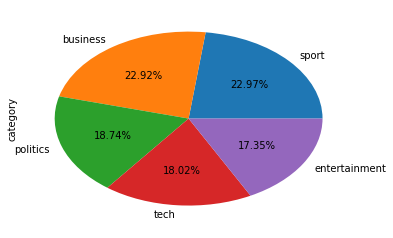

In [19]:
df['category'].value_counts().plot(kind='pie',autopct='%.2f%%') # almost equally distributed

In [4]:
def clean_articles(df):

    # remove all the new lines and spaces if there are any : - \r and \n
    print('Step 1: Replacing...')
    
    df['text'] = df['text'].str.replace("\r", " ")
    df['text'] = df['text'].str.replace("\n", " ")
    df['text'] = df['text'].str.replace("    ", " ")
    df['text'] = df['text'].str.replace('"', '') # remove double quotes
    df['text'] = df['text'].str.lower()  # make all the words as lower case
    
    for sign in signs:
        df['text'] = df['text'].str.replace(sign, '') # remove any special punctuations
        
    # remove Deshwal's the trailing s as it does not add any information in classification
    df['text'] = df['text'].str.replace("'s", "")


    print('Step 2: Lemmatizing......')
    
    nrows = len(df)
    lemmatized_text_list = []

    for row in range(nrows):
        lemmatized_list = [] # Create an empty list containing lemmatized words
        text = df.loc[row]['text'] # Save the text and its words into an object
        text_words = text.split(" ")

        for word in text_words:  # Iterate through every word to lemmatize
            lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

        lemmatized_text = " ".join(lemmatized_list)  # Join the list to get a string
        lemmatized_text_list.append(lemmatized_text) # Append to the list containing the texts

    df['text'] = lemmatized_text_list
    
    
    print('Step 3: Removing Stop Words....')
    
    for stop_word in stop_words:
        re_sw = r"\b" + stop_word + r"\b"
        df['text'] = df['text'].str.replace(re_sw, '')


In [5]:
clean_articles(df)

Step 1: Replacing...
Step 2: Lemmatizing......
Step 3: Removing Stop Words....


In [6]:
def tokenize_articles(df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df.text)
    df['words'] = tokenizer.texts_to_sequences(df.text)
    
    return tokenizer

In [7]:
tokenizer = tokenize_articles(df)

df['article_length'] = df.words.apply(lambda i: len(i)) # if article length is less than 10, drop it
df = df[df['article_length']>=10]

In [8]:
df.article_length.describe()

count    2225.000000
mean      222.154607
std       126.370837
min        48.000000
25%       145.000000
50%       195.000000
75%       273.000000
max      2212.000000
Name: article_length, dtype: float64

In [9]:
maxlen = 275 # 75 percentile is 273
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

df['encoded_cat'] = LabelEncoder().fit_transform(df['category'])

# Glove embedding

In [10]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Unique tokens: {len(word_index)}')
print(f'Total Word Vectors: {len(embeddings_index)}')

Unique tokens: 27859
Total Word Vectors: 400000


In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split Data

In [12]:
X = np.array(X)
Y = np_utils.to_categorical(df['encoded_cat'].tolist())

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Attention Layer

In [13]:
class Attention(Layer):
    '''
    Implement Attention is all you need's Bhadanau's style Attention
    '''
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

# Custom Metric

In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
embedding_layer = Embedding(len(word_index)+1,EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),input_length=maxlen,
                            trainable=False) # do not train as these are GloVe pre trained

In [16]:
inp = Input(shape=(maxlen,), dtype='int32')
embedding= embedding_layer(inp)
attention_out = Attention(maxlen)(embedding)
flat = Dense(512, activation='relu')(attention_out)
flat = Dropout(0.63)(flat)
flat = BatchNormalization()(flat)
out = Dense(5,activation='softmax')(flat)

AttentionModel = Model(inputs=inp, outputs=out)
AttentionModel.compile(loss='categorical_crossentropy', optimizer='adam', 
                       metrics=['acc',recall_m,precision_m,f1_m])

AttentionModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 275)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 275, 100)          2786000   
_________________________________________________________________
attention_1 (Attention)      (None, 100)               375       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total para

In [17]:
mcp = ModelCheckpoint(filepath='/kaggle/working/best_weights.h5',verbose=1,save_best_only=True,
                      save_weights_only=True)
es = EarlyStopping(min_delta=0.003,patience=2,verbose=1)
rlp = ReduceLROnPlateau(factor=0.003,patience=1,verbose=1,min_delta=0.001,min_lr=1e-6)

callbacks = [mcp,es,rlp]

In [18]:
training_history = AttentionModel.fit(x_train,y_train,batch_size=32,epochs=10,
                                      validation_data=(x_val, y_val),callbacks=callbacks)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 [==============================] - 2s 1ms/step - loss: 0.5368 - acc: 0.8163 - recall_m: 0.7483 - precision_m: 0.8768 - f1_m: 0.7983 - val_loss: 0.1690 - val_acc: 0.9551 - val_recall_m: 0.9461 - val_precision_m: 0.9635 - val_f1_m: 0.9545

Epoch 00001: val_loss improved from inf to 0.16896, saving model to /kaggle/working/best_weights.h5
Epoch 2/10
1780/1780 [==============================] - 1s 548us/step - loss: 0.2295 - acc: 0.9360 - recall_m: 0.9107 - precision_m: 0.9490 - f1_m: 0.9292 - val_loss: 0.1386 - val_acc: 0.9573 - val_recall_m: 0.9573 - val_precision_m: 0.9661 - val_f1_m: 0.9616

Epoch 00002: val_loss improved from 0.16896 to 0.13858, saving model to /kaggle/working/best_weights.h5
Epoch 3/10
1780/1780 [==============================] - 1s 506us/step - loss: 0.2005 - acc: 0.9421 - recall_m: 0.9270 - precision_m: 0.9550 - f1_m: 0.9406 - val_loss: 0.1062 - val_acc: 0.9640 - val_recall_m: 0.9640 - val_precisio

# Improvements
Training the model took less than a minute using Attention Model and has given us `validation accuracy = 0.9798` without overfitting. We can improve the accuracy by adding either BiDirectional LSTM or GRU cell before AttentionLayer but computation to metric ration won't improve much. 

For the best results, we can use HuggingFace Library's pre-trained SOTA models.